# Compulsory 1 - Erlend Risvik

The first part of the compulsory is setting up Cassandra and PySpark, making sure everything works.

## Set up Cassandra

In [1]:
# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

In [117]:
# Set up new keyspace (first time only)
#                                              name of keyspace                        replication strategy           replication factor
session.execute("CREATE KEYSPACE IF NOT EXISTS compulsory WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };")

In [2]:
# Create a new table (first time only)
session.set_keyspace('compulsory')

# Create a new table (observe keys)
session.execute("DROP TABLE IF EXISTS compulsory.car_table;")
session.execute("CREATE TABLE IF NOT EXISTS car_table (company text, model text, PRIMARY KEY(company, model));")

In [3]:
# Insert some data (combination of company and model must be unique)
session.execute("INSERT INTO car_table (company, model) VALUES ('Tesla', 'Model S');")
session.execute("INSERT INTO car_table (company, model) VALUES ('Tesla', 'Model 3');")
session.execute("INSERT INTO car_table (company, model) VALUES ('Polestar', '3');")
session.execute("INSERT INTO car_table (company, model) VALUES ('Volkswagen', 'ID.4');")
session.execute("INSERT INTO car_table (company, model) VALUES ('Nissan', 'Leaf');")

In [4]:
# Query the data
query = "SELECT * FROM compulsory.car_table;"
rows = session.execute(query)
for i in rows:
    print(i)

# Close the connection
session.shutdown()
cluster.shutdown()

Row(company='Nissan', model='Leaf')
Row(company='Polestar', model='3')
Row(company='Volkswagen', model='ID.4')
Row(company='Tesla', model='Model 3')
Row(company='Tesla', model='Model S')


## Set up PySpark

In [161]:
# Set enviorment variables
import os

#os.environ["SPARK_HOME"] = 'C:\\Users\erlen\.conda\pkgs\pyspark-3.4.1-pyhd8ed1ab_0\site-packages\pyspark'
#os.environ["JAVA_HOME"] = 'C:\Program Files\Java\jdk-20'
#os.environ["HADOOP_HOME"] = 'C:\hadoop-3.3.6'
os.environ["PYSPARK_PYTHON"] = "python"

In [5]:
from pyspark.sql import SparkSession

# Set up spark session
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

In [6]:
# Load dummy table and see if it works
spark.read.format("org.apache.spark.sql.cassandra").options(table="car_table", keyspace="compulsory").load().show()

+----------+-------+
|   company|  model|
+----------+-------+
|    Nissan|   Leaf|
|  Polestar|      3|
|     Tesla|Model 3|
|     Tesla|Model S|
|Volkswagen|   ID.4|
+----------+-------+



Great, everything is set up to work.

## Loading the fish health data 

We start by setting up the API and getting proper access.

In [1]:
import requests
# Set up request
def get_access_token():
    """Function to get access token from Barentswatch API

    Returns:
        str: Access token
    """
    url = "https://id.barentswatch.no/connect/token"
    # Read secret key from file
    secret_key = open(r'..\..\IND320\No_sync\fish_api', 'r').read()

    # Set up request to get access token
    headers = {
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {
        "client_id": "erlend.risvik@gmail.com:fishclient",
        "scope": "api",
        "client_secret": secret_key,
        "grant_type": "client_credentials"
    }

    response = requests.post(url, headers=headers, data=data)
    return response.json()['access_token']

Next, we test the API by selecting an arbitrary part of the data

In [3]:
def get_fish_data(year, week, access_token):
    """Function to get fish data from Barentswatch API.
    
    Parameters:
    -----------
    year : int
        Year of data
    week : int
        Week of data
    access_token : str
        Access token from Barentswatch API
    Returns:
    --------
    json: json object with data
    """

    url = f"https://www.barentswatch.no/bwapi/v1/geodata/fishhealth/locality/{year}/{week}"

    headers = {
        "Authorization": "Bearer "+ access_token}

    df = requests.get(url, headers = headers).json()
    return df

access_token = get_access_token()
test = get_fish_data(year = 2015, week = 1, access_token=access_token)
test


{'year': 2015,
 'week': 1,
 'localities': [{'localityNo': 14746,
   'localityWeekId': 713317,
   'name': 'Aarsand',
   'hasReportedLice': False,
   'isFallow': True,
   'avgAdultFemaleLice': None,
   'hasCleanerfishDeployed': False,
   'hasMechanicalRemoval': False,
   'hasSubstanceTreatments': False,
   'hasPd': False,
   'hasIla': False,
   'municipalityNo': '1811',
   'municipality': 'Bindal',
   'lat': 65.045867,
   'lon': 12.156933,
   'isOnLand': False,
   'inFilteredSelection': True,
   'hasSalmonoids': False,
   'isSlaughterHoldingCage': False},
  {'localityNo': 12765,
   'localityWeekId': 295408,
   'name': 'Aasen Gård',
   'hasReportedLice': False,
   'isFallow': True,
   'avgAdultFemaleLice': None,
   'hasCleanerfishDeployed': False,
   'hasMechanicalRemoval': False,
   'hasSubstanceTreatments': False,
   'hasPd': False,
   'hasIla': False,
   'municipalityNo': '0439',
   'municipality': 'Folldal',
   'lat': 62.093517,
   'lon': 9.973667,
   'isOnLand': True,
   'inFilteredS

In [4]:
def get_lice_count_data(localty, year, week, access_token):
    """Function to get lice count data from Barentswatch API.

    Parameters:
    -----------
    year : int
        Year of data
    week : int
        Week of data
    access_token : str
        Access token from Barentswatch API

    Returns:
    --------
    json: json object with data 
    """

    url = f'https://www.barentswatch.no/bwapi/v1/geodata/fishhealth/locality/{localty}/{year}/{week}'
    headers = {
        "Authorization": "Bearer "+ access_token}
    
    df = requests.get(url, headers=headers).json()
    return df


test = get_lice_count_data(localty = 12765, year = 2015, week = 1, access_token=access_token)
test
    

{'ilaSurveillanceZones': [],
 'ilaProtectionZones': [],
 'pdSurveillanceZones': [],
 'pdProtectionZones': [],
 'localityName': 'Aasen Gård',
 'localityWeek': {'id': 295408,
  'localityNo': 12765,
  'year': 2015,
  'week': 1,
  'hasReportedLice': False,
  'hasMechanicalRemoval': False,
  'hasBathTreatment': False,
  'hasInFeedTreatment': False,
  'hasCleanerFishDeployed': False,
  'isFallow': True,
  'avgAdultFemaleLice': None,
  'avgMobileLice': None,
  'avgStationaryLice': None,
  'seaTemperature': None,
  'bathTreatments': [],
  'inFeedTreatments': [],
  'cleanerFish': None,
  'mechanicalRemoval': None,
  'timeSinceLastChitinSynthesisInhibitorTreatment': None,
  'hasSalmonoids': True,
  'isSlaughterHoldingCage': False},
 'ilaPd': [],
 'ilaPdCase': None,
 'aquaCultureRegister': {'localityNo': 12765,
  'name': 'Aasen Gård',
  'municipalityNo': '0439',
  'municipality': 'Folldal',
  'placement': 'LAND',
  'capacity': 600.0,
  'unit': 'KG',
  'purposes': 'Kommersiell',
  'productionTypes

Now we want to create a function to get one year's worth of data. It will take an arbitrary year and get data for weeks 1-52.

In [5]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None # ignore copy of df warning

# Select data from localty and make it into a dataframe with columns
def get_all_fish_data(year, access_token):
    """Function to get all fish data from Barentswatch API limited to one year.

    Parameters:
    -----------
    access_token : str
        Access token from Barentswatch API
    Returns:
    --------
    df: pandas dataframe with data
    """

    weeks = np.arange(1, 53)
    df = pd.DataFrame()
    for i in range(len(weeks)):
        data = get_fish_data(year = year, week = weeks[i], access_token = access_token)["localities"]
        data = pd.DataFrame(data)
        data["year"] = year
        data["week"] = weeks[i]
        df = pd.concat([df, data], ignore_index=True)
    df.columns = df.columns.str.lower()
    return df

def get_all_lice_count_data(localty, year, access_token):
    """
    Function to get all lice count data from Barentswatch API limited to one year.

    Parameters:
    -----------
    localty : int
        Localty number
    year : int
        Year of data
    access_token : str
        Access token from Barentswatch API
    Returns:
    --------
    df: pandas dataframe with data
    """
    weeks = np.arange(1, 53)
    df = pd.DataFrame()
    for i in range(len(weeks)):
        data = get_lice_count_data(localty = localty, year = year, week = weeks[i], access_token = access_token)["localityWeek"]
        for key, value in data.items():
            data[key] = [value]
        data = pd.DataFrame(data).drop(columns = ["bathTreatments", "cleanerFish", "inFeedTreatments", "mechanicalRemoval", "timeSinceLastChitinSynthesisInhibitorTreatment"]) # These contain potentially nested dictionaries which make it tricky to convert to spark
        data["year"] = year
        data["week"] = weeks[i]

        df = pd.concat([df, data], ignore_index=True)
    df.columns = df.columns.str.lower()

    return df
df_fish = get_all_fish_data(year = 2015, access_token = access_token)
df_lice = get_all_lice_count_data(localty = 24175, year = 2015, access_token = access_token)

In [6]:
df_fish.head()

,localityno,localityweekid,name,hasreportedlice,isfallow,avgadultfemalelice,hascleanerfishdeployed,hasmechanicalremoval,hassubstancetreatments,haspd,...,municipalityno,municipality,lat,lon,isonland,infilteredselection,hassalmonoids,isslaughterholdingcage,year,week
0,14746,713317,Aarsand,False,True,NaN,False,False,False,False,...,1811,Bindal,65.045867,12.156933,False,True,False,False,2015,1
1,12765,295408,Aasen Gård,False,True,NaN,False,False,False,False,...,0439,Folldal,62.093517,9.973667,True,True,True,False,2015,1
2,31937,717087,Abelsnes,False,True,NaN,False,False,False,False,...,1004,Flekkefjord,58.238767,6.656650,True,True,False,False,2015,1
3,10665,443570,Adamselv,False,True,NaN,False,False,False,False,...,2022,Lebesby,70.410660,26.687325,True,True,True,False,2015,1
4,29196,836973,Adjetjohka,False,True,NaN,False,False,False,False,...,2011,Guovdageaidnu-Kautokeino,68.944137,22.918715,True,True,False,False,2015,1


In [7]:
df_lice.head()

,id,localityno,year,week,hasreportedlice,hasmechanicalremoval,hasbathtreatment,hasinfeedtreatment,hascleanerfishdeployed,isfallow,avgadultfemalelice,avgmobilelice,avgstationarylice,seatemperature,hassalmonoids,isslaughterholdingcage
0,187264,24175,2015,1,False,False,False,False,False,False,NaN,NaN,NaN,5.3,True,False
1,187265,24175,2015,2,True,False,False,False,False,False,0.0,0.0,0.0,5.0,True,False
2,187266,24175,2015,3,True,False,False,False,False,False,0.0,0.0,0.0,4.5,True,False
3,187267,24175,2015,4,True,False,False,False,False,False,0.0,0.0,0.0,4.5,True,False
4,187268,24175,2015,5,False,False,False,False,False,False,NaN,NaN,NaN,3.7,True,False


## Adding fish health data to cassandra database using pyspark

Now that we have the data, we want to add it to the database. 

In [8]:
from pyspark.sql import SparkSession
import os

#os.environ["SPARK_HOME"] = 'C:\\Users\erlen\.conda\pkgs\pyspark-3.4.1-pyhd8ed1ab_0\site-packages\pyspark'
#os.environ["HADOOP_HOME"] = 'C:\hadoop-3.3.6'

#os.environ["JAVA_HOME"] = 'C:\Program Files\Java\jdk-20'
#os.environ["SPARK_HOME"] = "C:\\Users\erlen\spark-3.5.0-bin-hadoop3"
#os.environ["HADOOP_HOME"] = "C:\\Users\erlen\spark-3.5.0-bin-hadoop3"

# THIS IS THE KEY
os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

def convert_to_spark(df):
    """Function to convert pandas dataframe to spark dataframe

    Parameters:
    -----------
    df : pandas dataframe
        Dataframe to convert

    Returns:
    --------
    spark dataframe
    """
    return spark.createDataFrame(df)

# Create a function to list all tables in cassandra
def list_tables():
    """
    Function to list all tables in cassandra
    """
    query = "SELECT * FROM system_schema.tables WHERE keyspace_name='compulsory';"
    rows = session.execute(query)
    for i in rows:
        print(i)

# Convert the pandas dataframes to spark dataframes
fish_spark = convert_to_spark(df_fish)
lice_spark = convert_to_spark(df_lice)

In [9]:
fish_spark.show()

+----------+--------------+------------+---------------+--------+------------------+----------------------+--------------------+----------------------+-----+------+--------------+--------------------+---------+---------+--------+-------------------+-------------+----------------------+----+----+
|localityno|localityweekid|        name|hasreportedlice|isfallow|avgadultfemalelice|hascleanerfishdeployed|hasmechanicalremoval|hassubstancetreatments|haspd|hasila|municipalityno|        municipality|      lat|      lon|isonland|infilteredselection|hassalmonoids|isslaughterholdingcage|year|week|
+----------+--------------+------------+---------------+--------+------------------+----------------------+--------------------+----------------------+-----+------+--------------+--------------------+---------+---------+--------+-------------------+-------------+----------------------+----+----+
|     14746|        713317|     Aarsand|          false|    true|               NaN|                 false|  

In [10]:
lice_spark.show()

+------+----------+----+----+---------------+--------------------+----------------+------------------+----------------------+--------+------------------+-------------+-----------------+--------------+-------------+----------------------+
|    id|localityno|year|week|hasreportedlice|hasmechanicalremoval|hasbathtreatment|hasinfeedtreatment|hascleanerfishdeployed|isfallow|avgadultfemalelice|avgmobilelice|avgstationarylice|seatemperature|hassalmonoids|isslaughterholdingcage|
+------+----------+----+----+---------------+--------------------+----------------+------------------+----------------------+--------+------------------+-------------+-----------------+--------------+-------------+----------------------+
|187264|     24175|2015|   1|          false|               false|           false|             false|                 false|   false|               NaN|          NaN|              NaN|           5.3|         true|                 false|
|187265|     24175|2015|   2|           true|   

We have to create a dictionary that maps the datatype of the columns to cassandra datatype.

In [11]:
# Iterate over all fish columns and print the column type
for i in df_fish.columns:
    print(i, df_fish[i].dtype)

localityno int64
localityweekid int64
name object
hasreportedlice bool
isfallow bool
avgadultfemalelice float64
hascleanerfishdeployed bool
hasmechanicalremoval bool
hassubstancetreatments bool
haspd bool
hasila bool
municipalityno object
municipality object
lat float64
lon float64
isonland bool
infilteredselection bool
hassalmonoids bool
isslaughterholdingcage bool
year int64
week int32


In [12]:
# Iterate over all lice columns and print the column type
for i in df_lice.columns:
    print(i, df_lice[i].dtype)

id int64
localityno int64
year int64
week int32
hasreportedlice bool
hasmechanicalremoval bool
hasbathtreatment bool
hasinfeedtreatment bool
hascleanerfishdeployed bool
isfallow bool
avgadultfemalelice float64
avgmobilelice float64
avgstationarylice float64
seatemperature float64
hassalmonoids bool
isslaughterholdingcage bool


Next, we create these dictionaries and use it to make the databases.

In [21]:
from cassandra.cluster import Cluster

cassandra_types_fish = {
    "localityno": "int",
    "localityweekid": "int",
    "name": "text",
    "hasreportedlice": "boolean",
    "isfallow": "boolean",
    "avgadultfemalelice": "float",
    "hascleanerfishdeployed": "boolean",
    "hasmechanicalremoval": "boolean",
    "hassubstancetreatments": "boolean",
    "haspd": "boolean",
    "hasila": "boolean",
    "municipalityno": "int",
    "municipality": "text",
    "lat": "float",
    "lon": "float",
    "isonland": "boolean",
    "infilteredselection": "boolean",
    "hassalmonoids": "boolean",
    "isslaughterholdingcage": "boolean",
    "year": "int",
    "week": "int"
}

cassandra_types_lice = {
    "id": "int",
    "localityno": "int",
    "year": "int",
    "week": "int",
    "hasreportedlice": "boolean",
    "hasmechanicalremoval": "boolean",
    "hasbathtreatment": "boolean",
    "hasinfeedtreatment": "boolean",
    "hascleanerfishdeployed": "boolean",
    "isfallow": "boolean",
    "avgadultfemalelice": "float",
    "avgmobilelice": "float",
    "avgstationarylice": "float",
    "seatemperature": "float",
    "hassalmonoids": "boolean",
    "isslaughterholdingcage": "boolean",
}

# Set up cassandra cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()
session.set_keyspace('compulsory')

# Create table for fish data
table_name_fish = "fish_data_full"
cql_create_table = f"""
    CREATE TABLE IF NOT EXISTS {table_name_fish} (
        localityno INT PRIMARY KEY,
        {', '.join([f"{i} {cassandra_types_fish[i]}" for i in fish_spark.columns if i != "localityno"])}
    );
""".replace("\n", " ")

session.execute(f"DROP TABLE IF EXISTS compulsory.{table_name_fish};")
session.execute(cql_create_table)

# Create table for lice data
table_name_lice = "lice_data_full"
cql_create_table = f"""
    CREATE TABLE IF NOT EXISTS {table_name_lice} (
        id INT PRIMARY KEY,
        {', '.join([f"{i} {cassandra_types_lice[i]}" for i in lice_spark.columns if i != "id"])}
    );
""".replace("\n", " ")

session.execute(f"DROP TABLE IF EXISTS compulsory.{table_name_lice};")
session.execute(cql_create_table)


Let's try to write to cassandra using a spark dataframe 

In [22]:
fish_spark.write.format("org.apache.spark.sql.cassandra")\
.options(table="fish_data_full", keyspace="compulsory").mode("append").save()

In [23]:
lice_spark.write.format("org.apache.spark.sql.cassandra")\
.options(table="lice_data_full", keyspace="compulsory").mode("append").save()

## Reading fish health data from cassandra database using spark

Now we test if we can read from the database using spark.

In [1]:
from pyspark.sql import SparkSession
import os

#os.environ["SPARK_HOME"] = 'C:\\Users\erlen\.conda\pkgs\pyspark-3.4.1-pyhd8ed1ab_0\site-packages\pyspark'
#os.environ["HADOOP_HOME"] = 'C:\hadoop-3.3.6'

#os.environ["JAVA_HOME"] = 'C:\Program Files\Java\jdk-20'
#os.environ["SPARK_HOME"] = "C:\\Users\erlen\spark-3.5.0-bin-hadoop3"
#os.environ["HADOOP_HOME"] = "C:\\Users\erlen\spark-3.5.0-bin-hadoop3"

# THIS IS THE KEY
os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()


ModuleNotFoundError: No module named 'pyspark'

In [29]:
spark.read.format("org.apache.spark.sql.cassandra").options(table="fish_data_full", keyspace="compulsory").load().createOrReplaceTempView("fish_data_full")
fish_data = spark.sql("select * from fish_data_full")
fish_data.show()

+----------+------------------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+--------------+---------+------------+--------------+--------------------+----+----+
|localityno|avgadultfemalelice|hascleanerfishdeployed|hasila|hasmechanicalremoval|haspd|hasreportedlice|hassalmonoids|hassubstancetreatments|infilteredselection|isfallow|isonland|isslaughterholdingcage|      lat|localityweekid|      lon|municipality|municipalityno|                name|week|year|
+----------+------------------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+--------------+---------+------------+--------------+--------------------+----+----+
|     12397|               NaN|                 false| false|               false|false|          false|     

In [33]:
fish_pandas = fish_data.toPandas()
fish_pandas.head()

,localityno,avgadultfemalelice,hascleanerfishdeployed,hasila,hasmechanicalremoval,haspd,hasreportedlice,hassalmonoids,hassubstancetreatments,infilteredselection,...,isonland,isslaughterholdingcage,lat,localityweekid,lon,municipality,municipalityno,name,week,year
0,13584,NaN,False,False,False,False,False,True,False,True,...,True,False,65.324356,326827,12.921740,Brønnøy,1813,Tosbotn,32,2015
1,10726,0.0,False,False,False,False,True,True,False,True,...,False,False,69.860085,115568,20.713966,Skjervøy,1941,Uløybukt,32,2015
2,13120,NaN,False,False,False,False,False,True,False,True,...,True,False,59.932133,307143,10.736450,Oslo,301,Veterinærinstituttet Oslo,32,2015
3,11334,NaN,False,False,False,False,False,True,False,True,...,False,False,68.731331,397583,17.234350,Gratangen,1919,Skjervika,32,2015
4,31117,NaN,False,False,False,False,False,True,False,True,...,False,False,60.156319,94060,5.713217,Fusa,1241,Skrubbo,32,2015


In [32]:
spark.read.format("org.apache.spark.sql.cassandra").options(table="lice_data_full", keyspace="compulsory").load().createOrReplaceTempView("lice_data_full")
lice_data = spark.sql("select * from lice_data_full")
lice_data.show()

+------+------------------+-------------+-----------------+----------------+----------------------+------------------+--------------------+---------------+-------------+--------+----------------------+----------+--------------+----+----+
|    id|avgadultfemalelice|avgmobilelice|avgstationarylice|hasbathtreatment|hascleanerfishdeployed|hasinfeedtreatment|hasmechanicalremoval|hasreportedlice|hassalmonoids|isfallow|isslaughterholdingcage|localityno|seatemperature|week|year|
+------+------------------+-------------+-----------------+----------------+----------------------+------------------+--------------------+---------------+-------------+--------+----------------------+----------+--------------+----+----+
|187314|              0.01|         0.22|             0.42|           false|                  true|             false|               false|           true|         true|   false|                 false|     24175|           5.0|  51|2015|
|187279|               0.0|          0.0|       

In [34]:
lice_pandas = lice_data.toPandas()
lice_pandas.head()

,id,avgadultfemalelice,avgmobilelice,avgstationarylice,hasbathtreatment,hascleanerfishdeployed,hasinfeedtreatment,hasmechanicalremoval,hasreportedlice,hassalmonoids,isfallow,isslaughterholdingcage,localityno,seatemperature,week,year
0,187307,0.02,0.06,0.84,False,True,False,False,True,True,False,False,24175,8.5,44,2015
1,187295,0.02,0.09,0.09,False,True,False,False,True,True,False,False,24175,11.8,32,2015
2,187315,0.04,0.15,0.21,False,True,False,False,True,True,False,False,24175,5.2,52,2015
3,187314,0.01,0.22,0.42,False,True,False,False,True,True,False,False,24175,5.0,51,2015
4,187279,0.00,0.00,0.12,False,False,False,False,True,True,False,False,24175,3.4,16,2015


Everything works :)

## Data visualization

Now we want to investigate proportions of localities that have reported Pancreas Disease (PD/Pd) during the chosen year, which in this case is 2015.

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the number of localities that have reported pd
pd_count = fish_pandas.groupby("haspd").count()["localityno"]
pd_count

haspd
False    1603
True      174
Name: localityno, dtype: int64

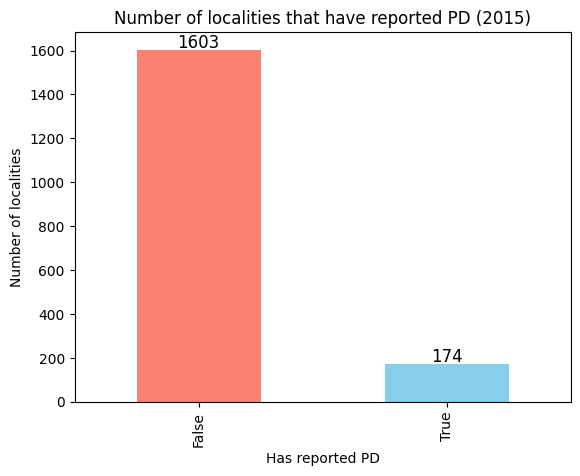

In [168]:
ax = (fish_pandas.groupby("haspd")
                .count()["localityno"]
                .plot(kind="bar", color=['salmon', 'skyblue']))

# Add counts above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

ax.set_title("Number of localities that have reported PD (2015)")
ax.set_ylabel("Number of localities")
ax.set_xlabel("Has reported PD")

plt.show()

As seen, 174 localities have reported PD in 2015.

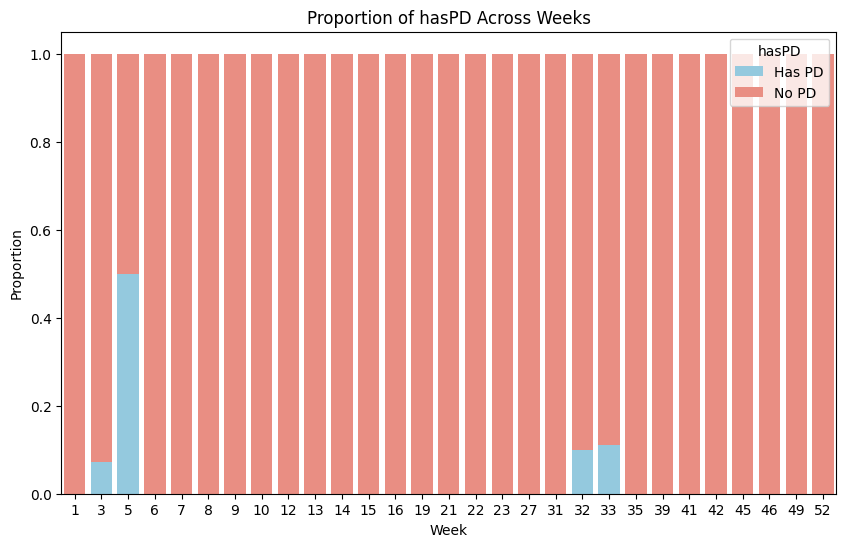

In [154]:
# Next, let's look at the proportion of localities across the weeks. To do this we need to group by week and then calculate the proportion of localities that have reported pd.
proportion_df = fish_pandas.groupby('week')['haspd'].value_counts(normalize=True).unstack(fill_value=0).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='week', y=True, data=proportion_df, color='skyblue', label='Has PD')
sns.barplot(x='week', y=False, data=proportion_df, color='salmon', label='No PD', bottom=proportion_df[True])
plt.title('Proportion of hasPD Across Weeks')
plt.xlabel('Week')
plt.ylabel('Proportion')
plt.legend(title='hasPD', loc='best')
plt.show()

This shows the proportion within each week. So for each week, the proportions sum to 1.

In [156]:
fish_pandas.groupby("week")["haspd"].value_counts()

week  haspd
1     False       3
3     False      13
      True        1
5     True        1
      False       1
6     False       5
7     False       2
8     False       2
9     False       1
10    False       2
12    False       3
13    False       2
14    False       1
15    False       1
16    False       2
19    False       2
21    False       3
22    False       1
23    False       3
27    False       1
31    False       1
32    False    1201
      True      131
33    False     331
      True       41
35    False       1
39    False       1
41    False       1
42    False       2
45    False       2
46    False       4
49    False       3
52    False       8
Name: count, dtype: int64

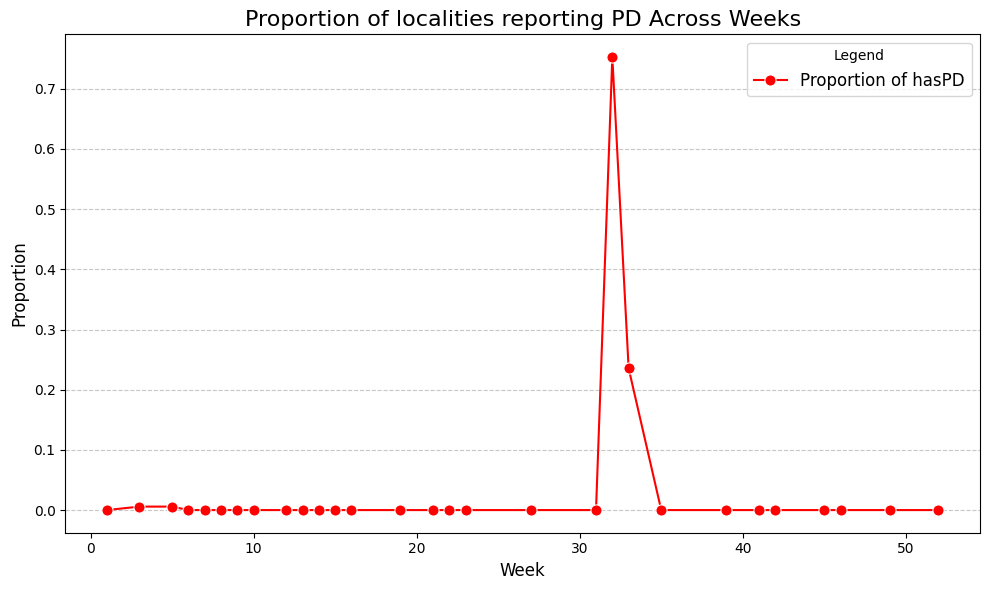

In [203]:
# Compute the proportion of localities that have reported pd for each week
proportion_df = fish_pandas.groupby('week')['haspd'].value_counts(normalize=False).unstack(fill_value=0).reset_index()[["week", True]]
# select "week" and "True"
proportion_df["prop"] = proportion_df[True] / proportion_df[True].sum()

# Plot the proportion of localities that have reported pd for each week
plt.figure(figsize=(10, 6))
sns.lineplot(x='week', y="prop", data=proportion_df, color="red", marker='o', markersize=8, label='Proportion of hasPD')
plt.title('Proportion of localities reporting PD Across Weeks', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Legend', fontsize=12)
plt.tight_layout()

plt.show()


Next, we want to plot lice count as a function of time

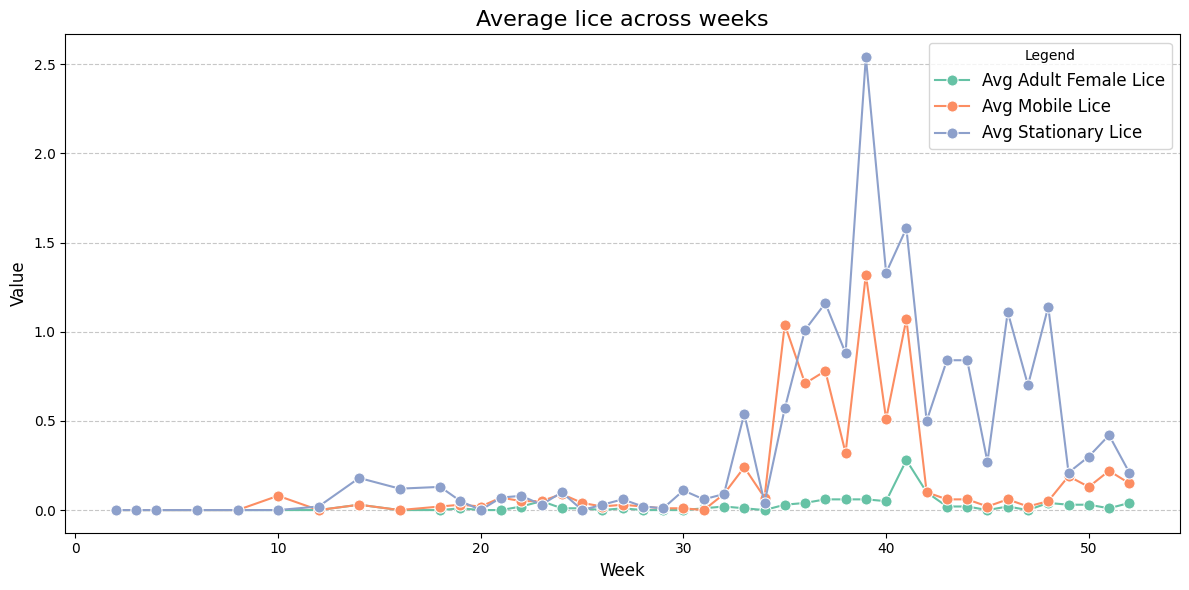

In [208]:
import seaborn as sns

# We want to plot the lice count as a function of time. That will be three line plots using avgadultfemalelice, avgmobilelice and avsgstationarylice as y-values and week as x-value. We will also plot the sea temperature as a function of time. That will be a line plot using seatemperature as y-value and week as x-value.

# First, we need to create a dataframe with the columns we want to plot. We will also add a column with the average of the three lice count columns.
lice_plot_df = lice_pandas[["week", "avgadultfemalelice", "avgmobilelice", "avgstationarylice"]]

custom_palette = sns.color_palette("Set2")

plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='avgadultfemalelice', data=lice_plot_df, marker='o', markersize=8, label='Avg Adult Female Lice', color=custom_palette[0])
sns.lineplot(x='week', y='avgmobilelice', data=lice_plot_df, marker='o', markersize=8, label='Avg Mobile Lice', color=custom_palette[1])
sns.lineplot(x='week', y='avgstationarylice', data=lice_plot_df, marker='o', markersize=8, label='Avg Stationary Lice', color=custom_palette[2])

plt.title('Average lice across weeks', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Legend', fontsize=12)
plt.tight_layout()

plt.show()